In [5]:
# coding: utf-8
import sys
sys.path.append('..')
import os
import numpy as np

In [6]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [7]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [8]:
# corpus 语料词汇id，来源自preprocess()
# vocab_size 词汇个数
# window_size 取当前单词前后多大窗口的单词
# return: 共现矩阵
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - 1  # 当前单词左边单词idx
            right_idx = idx + 1 # 当前单词右边单词idx
            
            # 如果当前单词左边存在相邻单词
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            # 如果当前单词右边存在相邻单词    
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [9]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
co_matrix = create_co_matrix(corpus, 7)
print(co_matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


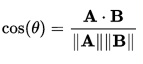

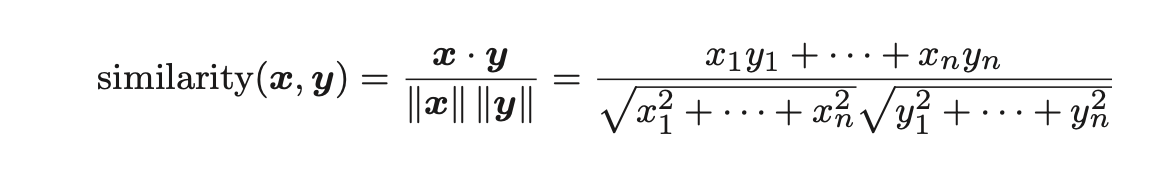

In [10]:
# 余弦相似度： 两向量点积 / 两向量L2范数的积    [-1, 1]
# eps: 微小值，防止零向量除零错误
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    
    return np.dot(nx, ny)

In [11]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text) 
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # you的单词向量
c1 = C[word_to_id['i']]   # i的单词向量 
print(cos_similarity(c0, c1))

0.7071067691154799


In [12]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
    if query not in word_to_id: 
        print('%s is not found' % query) 
        return
    
    # 获取查询的单词向量
    print('\n[query] ' + query) 
    query_id = word_to_id[query] 
    query_vec = word_matrix[query_id]
    
    # 获取语料中每个单词与当前查询词的余弦相似度
    vocab_size = len(id_to_word) 
    similarity = np.zeros(vocab_size) 
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    count = 0
    # -1 * similarity 表示降序
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query: 
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        # 打印 top x
        count += 1
        if count >= top:
            return

In [14]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text) 
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
most_similar('you', word_to_id, id_to_word, C, top=5)
# 语料库太小，导致 hello、goodbye和you的余弦相似度也很高


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## PMI (pointwise mutual information)
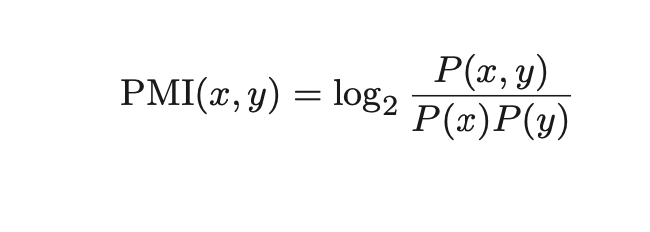
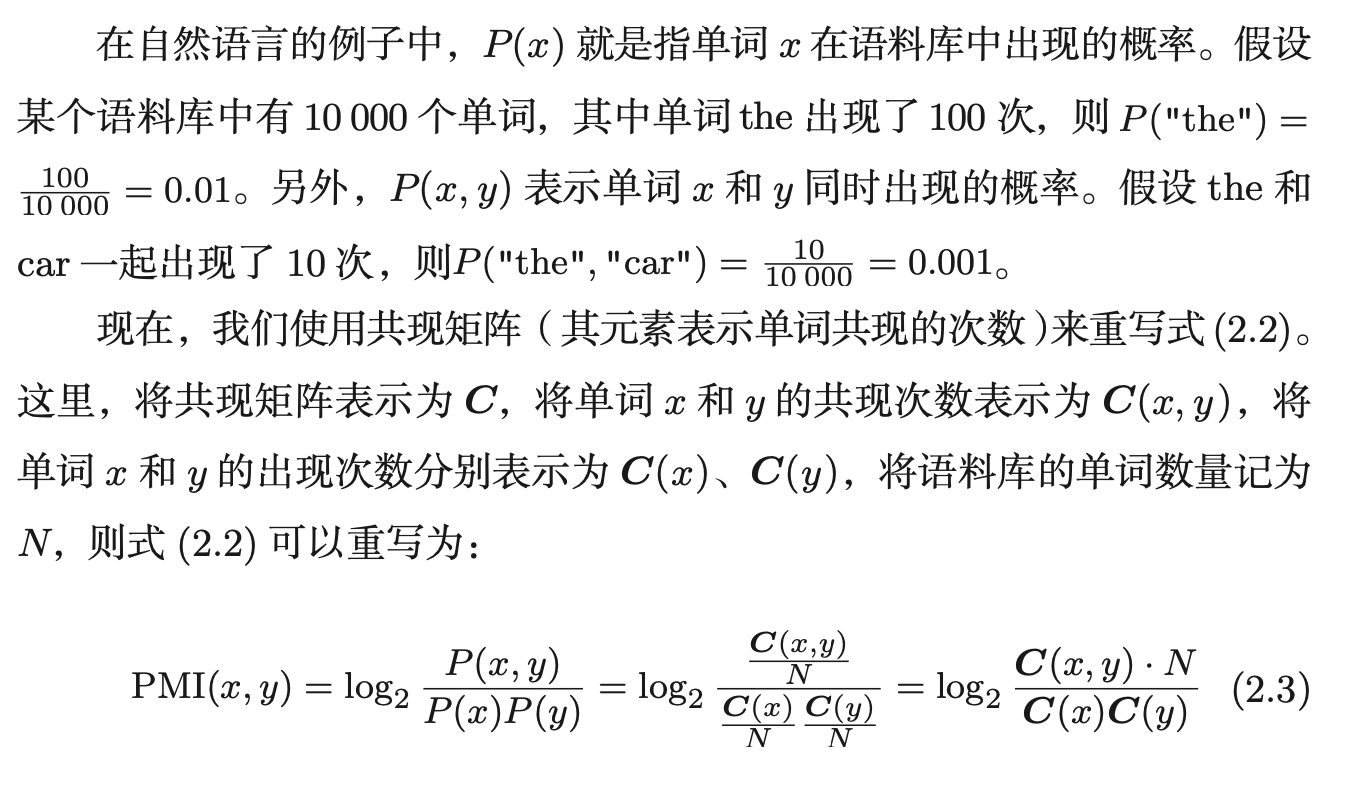
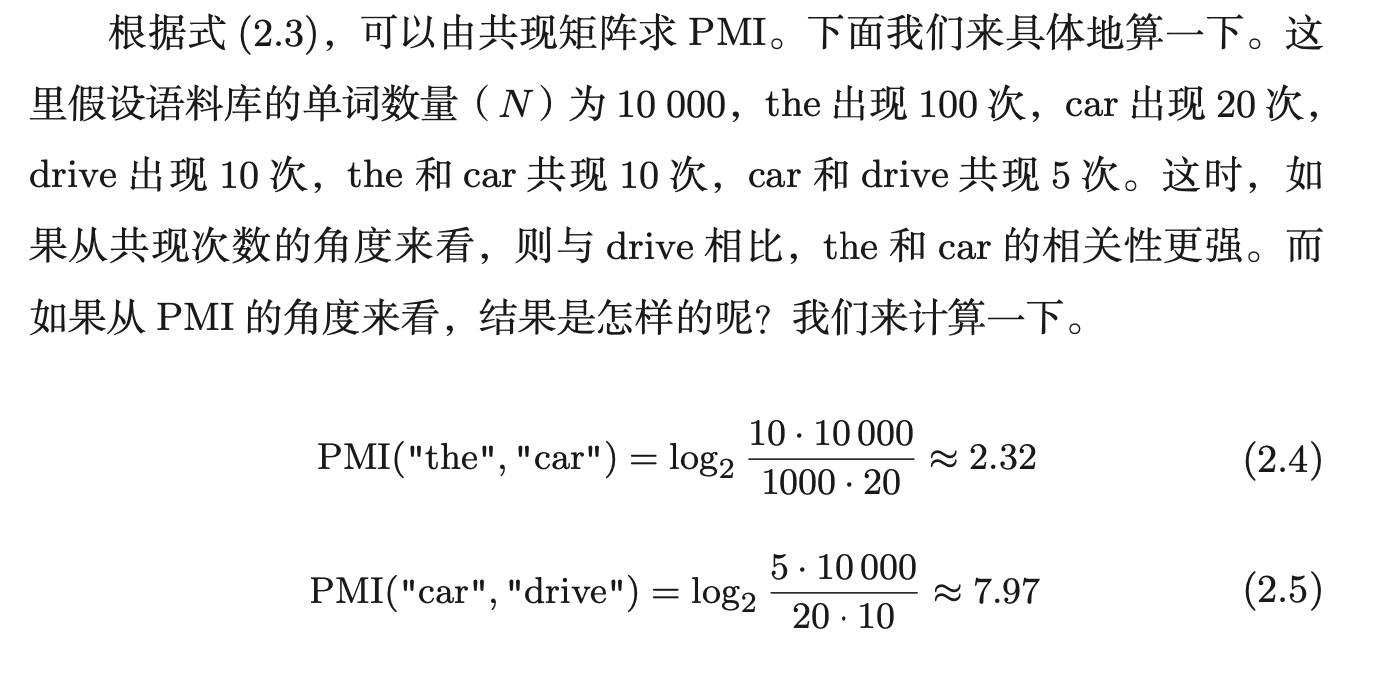

## PPMI (positive pointwise mutual information) 
解决 log20 = −∞ 问题

## 共现矩阵
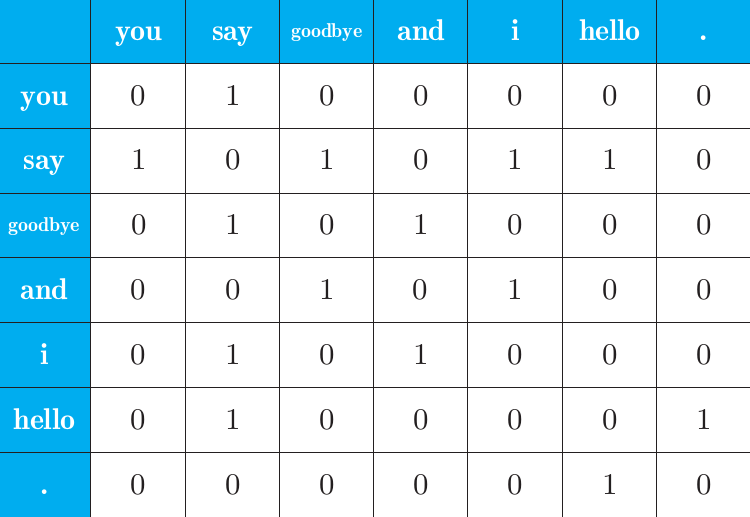

In [15]:
 def ppmi(C, verbose=False, eps = 1e-8):
        
        '''生成PPMI（正的点互信息）

        :param C: 共现矩阵
        :param verbose: 是否输出进展情况
        :return: ppmi矩阵
        
        PMI值越高，表示单词间相关性越强
        '''
        M = np.zeros_like(C, dtype=np.float32)
        N = np.sum(C) # 词库单词总数
        S = np.sum(C, axis=0)  # S[i]: 第i个单词出现的总次数
        
        total = C.shape[0] * C.shape[1]
        cnt = 0
        
        # 循环遍历矩阵每个元素
        for i in range(C.shape[0]):
            for j in range(C.shape[1]):
                pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
                M[i, j] = max(0, pmi)
                
                if verbose:
                    cnt += 1
                    if cnt % (total//100 + 1) == 0:
                        print('%.1f%% done' % (100*cnt/total))
        return M

In [16]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 有效位数为3位
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


## 奇异值分解 Singular Value Decomposition, SVD

$$ X = US{A}^T $$

U,V是列向量彼此正交的正交矩阵， 即:
$$ U{V}^T = V{U}^T = I $$

用于去除PMI矩阵中不重要的0元素

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 0.000e+00  3.409e-01 -3.886e-16 -1.205e-01 -1.110e-16 -9.323e-01
 -1.086e-16]


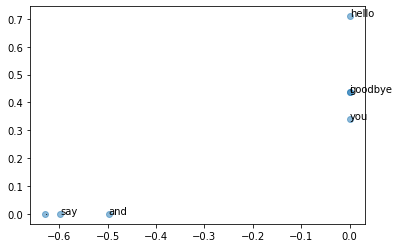

In [17]:
import matplotlib.pyplot as plt

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 有效位数为3位
print(C[0])  # 共现矩阵
print(W[0])  # PPMI矩阵
print(U[0])  # SVD矩阵

# plot
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()


In [18]:
def create_contexts_target(corpus, window_size=1):
    '''生成上下文和目标词

    :param corpus: 语料库（单词ID列表）
    :param window_size: 窗口大小（当窗口大小为1时，左右各1个单词为上下文）
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    # range left param is exclusive
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [28]:
def convert_one_hot(corpus, vocab_size):
    '''转换为one-hot表示

    :param corpus: 单词ID列表（一维或二维的NumPy数组）
    :param vocab_size: 词汇个数
    :return: one-hot表示（二维或三维的NumPy数组）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [32]:
corpus, word_to_id, id_to_word = preprocess("You say goodbye and I say hello.")
print(corpus)
contexts, target = create_contexts_target(corpus)
print(contexts)
# target 本质是取list第二个到倒数第二个，主要是context要取3位窗口的subList，但要排除中间元素
print(target)

vocab_size = len(word_to_id)
target_one_hot = convert_one_hot(target, vocab_size)
contexts_one_hot = convert_one_hot(contexts, vocab_size)

print("\n")
print('target_one_hot:')
print(target_one_hot)
print("\n")
print('contexts_one_hot:')
print(contexts_one_hot)

[0 1 2 3 4 1 5 6]
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


target_one_hot:
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


contexts_one_hot:
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


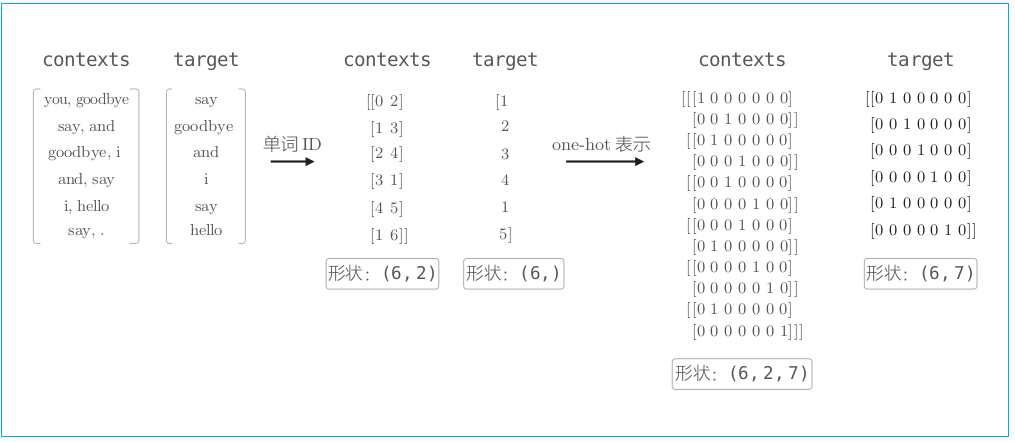

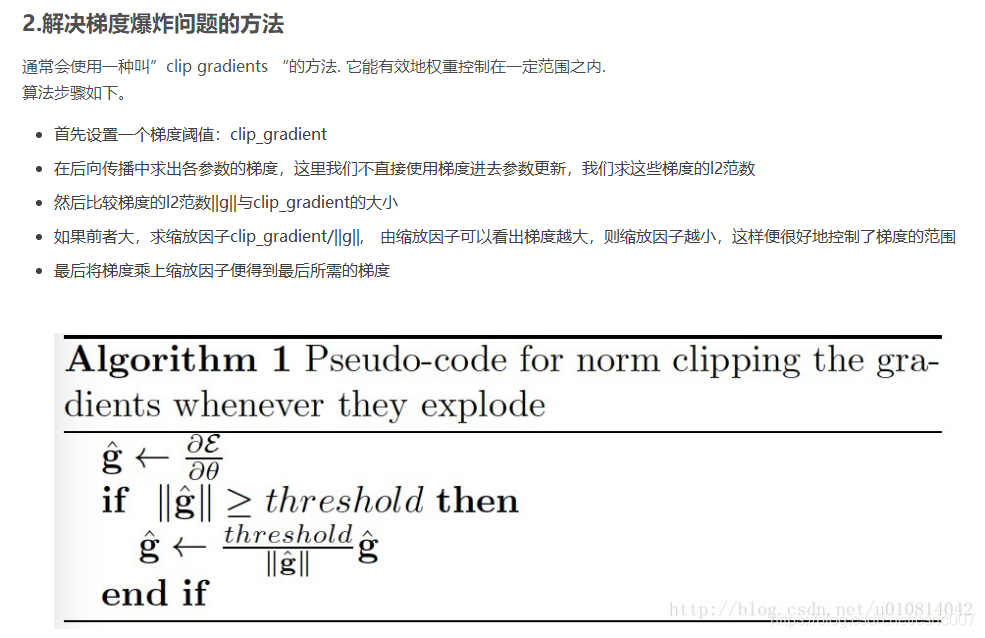

In [33]:
# 梯度裁剪 解决梯度爆炸
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate